<a href="https://colab.research.google.com/github/Tuvarh/fagkveld_170222/blob/main/20220217_Fagkveld_Kode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
! pip install munch transformers emoji

     |████████████████████████████████| 3.5 MB 4.6 MB/s 
     |████████████████████████████████| 174 kB 13.0 MB/s 
     |████████████████████████████████| 596 kB 54.8 MB/s 
     |████████████████████████████████| 6.8 MB 43.8 MB/s 
     |████████████████████████████████| 67 kB 4.9 MB/s 
     |████████████████████████████████| 895 kB 50.9 MB/s 
  Created wheel for emoji: filename=emoji-1.6.3-py3-none-any.whl size=170298 sha256=64e58b57cc40c68d480e19c3a1dd6e357abf4cbcdcb77821be0e9831eaef2812
  Stored in directory: /root/.cache/pip/wheels/03/8b/d7/ad579fbef83c287215c0caab60fb0ae0f30c4d7ce5f580eade
Successfully built emoji
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
data_path= "/content/fagkveld/data"
model_path= "/content/fagkveld/trained_models"

!mkdir fagkveld
!mkdir $model_path 
!mkdir $data_path 
 
!cp -r "drive/MyDrive/fagkveld/trained_models" "fagkveld"
!cp -r "drive/MyDrive/fagkveld/data" "fagkveld"
!cp -r "drive/MyDrive/fagkveld/model" "fagkveld"
!cp -r "drive/MyDrive/fagkveld/login" "fagkveld"


# Part 1  - Extract Twitter data


## Imports 

In [ ]:
import os
import pandas as pd
import tweepy
from pathlib import Path
import yaml
import time
import numpy as np

import panel as pn
import panel.widgets as pnw



## Establish connection to Twitter API

These keys will be deactivated after this workshop. To create new keys go to https://developer.twitter.com/en/portal and sign in with your twitter account 

In [ ]:
# Read secrets 
filepath_yaml="fagkveld/login/twitter.yaml"
with open(filepath_yaml) as file:
    config = yaml.safe_load(file)
CONSUMER_KEY=config["twitter_api"]["CONSUMER_KEY"]
CONSUMER_SECRET=config["twitter_api"]["CONSUMER_SECRET"]
OAUTH_TOKEN=config["twitter_api"]["OAUTH_TOKEN"]
OAUTH_TOKEN_SECRET=config["twitter_api"]["OAUTH_TOKEN_SECRET"]

# Set up authentication 
auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(OAUTH_TOKEN, OAUTH_TOKEN_SECRET)
api = tweepy.API(auth, wait_on_rate_limit=True)

## Functions for downloading twitter

In [ ]:

def get_twitter_msg(user, number_of_tweets):
    """ Function for extracting twitter messages for a user """ 
    user_df=pd.DataFrame()
    
    try:
        for tweet in tweepy.Cursor(api.user_timeline, screen_name=user,since="2000-01-01").items(number_of_tweets):
            dict_add={"text": tweet.text,"time_created":tweet.created_at,"user":user, "language":tweet.lang, "retweet":tweet.retweeted}
            user_df=user_df.append(dict_add,ignore_index=True)
    except:
        pass
    if user_df.shape[0]==0:
        raise Exception("No data downloaded")
    else:
        user_df.to_csv(f"{data_path}/single_users/{user}.csv", index=False)
def create_peer_group(peer_group, peer_group_name):
    """ Create a trainingset """ 
    
    df_list=[]
    
    for score, user in enumerate(peer_group):
        user_df=pd.read_csv(f"{data_path}/single_users/{user}.csv")
        df_list.append(user_df)
    # save to a master df    
    df_master=pd.concat(df_list)
    df_master.reset_index(drop=True, inplace=True)

    
    #save
    path=Path(f"{data_path}/train")
    path.mkdir(parents=True, exist_ok=True)
    df_master.to_csv(path / f"{peer_group_name}.csv")
    

## GUI for selecting Twitter user

In [ ]:

pn.extension()
#-------------- Help functions
def load_peer_group(multi_choice):
    possible_peer_groups= [x.parts[-1].replace(".csv","") for x in Path(f"{data_path}/train/").glob('*.csv')]
    multi_choice.options=possible_peer_groups
    multi_choice.value=possible_peer_groups
    
def load_users(new_choice,multi_choice):
    possible_users= [x.parts[-1].replace(".csv","") for x in Path(f"{data_path}/single_users/").glob('*.csv')]
    current_selections=multi_choice.value
    multi_choice.options=possible_users
    multi_choice.value=new_choice +current_selections

# --------------- Download twitter stream 
pn.extension(loading_spinner='dots', loading_color='#00aa41')
user_input = pn.widgets.TextInput(name='Write in a Twitter user (press [Spacebar] + [Enter] to download)', placeholder='Enter @twitter_username...')
number_of_tweets=pnw.IntSlider(name='# number of tweets to download', value=20, start=1, end=3500)
status_text = pn.pane.Str('                                                ', style={'font-size': '12pt'})

twitter_data=pn.Column("<br>\n# Add twitter users to list",number_of_tweets, user_input,status_text)


# - --------------- Create peer gropup
multi_choice_single = pn.widgets.MultiChoice(name='Select users to combine', value=[],
    options=[])

peer_group_name = pn.widgets.TextInput(name='Name of peer group (used for training)', placeholder='Enter a peer group name...')
multi_choice_single = pn.widgets.MultiChoice(name='Peers ', value=[],
    options=[])
multi_choice_peer_group = pn.widgets.MultiChoice(name='peer groups created', value=[],
    options=[], disabled=True)


possible_users= [x.parts[-1].replace(".csv","") for x in Path(f"{data_path}/single_users/").glob('*.csv')]
load_users(possible_users,multi_choice_single)
load_peer_group(multi_choice_peer_group)

peer_group_data=pn.Column("<br>\n# Select users for a peer group", multi_choice_single,peer_group_name,multi_choice_peer_group)

# - --------------- Dependencies 
@pn.depends(peer_group_name, watch=True)
def combine_data(event, multi_choice_peer_group=multi_choice_peer_group,multi_choice_single=multi_choice_single,name=peer_group_name):
    create_peer_group(multi_choice_single.value,name.value)
    load_peer_group(multi_choice_peer_group)

@pn.depends(user_input, watch=True)
def load_data(event,user=user_input,status_text=status_text,multi_choice=multi_choice_single,num_tweets=number_of_tweets):
    
    user.disabled=True
    user_list= [x.strip() for x in user.value.strip().split(" ")]
    error_list=[]
    success_list=[]
    status_text.object=f'Started downloading'     
    for twitter_user in user_list:
        try:
            status_text.object=f'Downloading twitter stream for {twitter_user}'     
            get_twitter_msg(twitter_user, num_tweets.value)
            success_list.append(twitter_user)
        except Exception as e:
            print(e)
            error_list.append(twitter_user)
            
    load_users(success_list,multi_choice)
    
    if len(error_list):
        status_text.object=f'Problems with downloading {error_list}\n but downloaded {success_list}' 
    else:
        status_text.object=f'Number tweets per user: {num_tweets.value},\n users: {success_list}'  
    user.disabled=False

pn.Row(twitter_data,peer_group_data)

Row
    [0] Column
        [0] Markdown(str)
        [1] IntSlider(end=3500, name='# number of t..., start=1, value=20)
        [2] TextInput(name='Write in a Twitter u..., placeholder='Enter @twitter_username.....)
        [3] Str(str, style={'font-size': '12pt'})
    [1] Column
        [0] Markdown(str)
        [1] MultiChoice(name='Peers ', options=['@mental_floss', ...], value=['@mental_floss', ...])
        [2] TextInput(name='Name of peer g..., placeholder='Enter a peer g...)
        [3] MultiChoice(disabled=True, name='peer groups created', options=['peer_group_code_example'...], value=['peer_group_code_example'...])

# Part 2 - Base model - Logistic regression

## Imports 

In [ ]:
from fagkveld.model.utils import PreprocessInputText
import munch
from pathlib import Path
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import pickle
import json
import dill

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix

# bag of words
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

#Visualization 
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS


#Visualization 
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import seaborn as sns

# Colors used 
cmap = clr.LinearSegmentedColormap.from_list('ANB color', ['#335B71',"#B0B9C0",'#B18E92'], N=256)



## Admin

In [ ]:
# Optional variables for simple model (linear regression):
VECTORIZER = "Trigram"  #choose between "BoW", "Trigram" and "TF-IDF". Default is "BoW"
ADD_EXTRA_FEATURES = False #True or False; Whether to add features for word count, emoji count and hashtag count as extra features when training model
    
PEER_GROUP_NAME="CHOOSE YOUR OWN GROUP"#"peer_group_code_example"

In [ ]:
model_dir = model_path+ f'/logistic_regression_{VECTORIZER.lower()}'
Path(model_dir).mkdir(parents=True, exist_ok=True)

#get data
data_examples = pd.read_csv(data_path + f"/train/{PEER_GROUP_NAME}.csv" )
data_examples.drop(columns=['Unnamed: 0'], inplace=True)

#labels for prediction
label_list = list(data_examples.user.unique())
label2id = {}
id2label = {}
for (i, label) in enumerate(label_list):
    label2id[label] = i
    id2label[i] = label
    


## Preprocessing

### Text cleaning: Prepare and preprocess data

In [ ]:
#create scores
label_id_array = []
for i, row in data_examples.iterrows(): 
    label_id_array.append(label2id[row['user']]) # class to numeric score
data_examples['score'] = label_id_array

#run text cleaning:
text_processor = PreprocessInputText()
print("------------Text cleaning------------")
#preprocess text
data_examples = text_processor.process_text(data_examples)

------------Text cleaning------------


### Prepare Text for training: Split data into training and validation sets


In [ ]:
elements = int(3200/5)
data_examples.sort_values(by="time_created",  axis =0, ascending=False, inplace=True)
validation_examples = data_examples.groupby('score').head(elements)
training_examples = data_examples[~data_examples.index.isin(validation_examples.index)]
val_index = validation_examples.index
train_index = training_examples.index

validation_examples = validation_examples.reset_index(drop=True)
training_examples = training_examples.sample(frac=1).reset_index(drop=True)

## Visualization of data using WordCloud

In [ ]:
# Define a function to plot word cloud
def plot_cloud(wordcloud, save_fig=False, path=model_dir, filename="WC.png"):
    # Set figure size
    fig = plt.figure(figsize=(15, 10))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");
    if save_fig:
        fig.savefig(path+"/"+filename)

### Text WordCloud

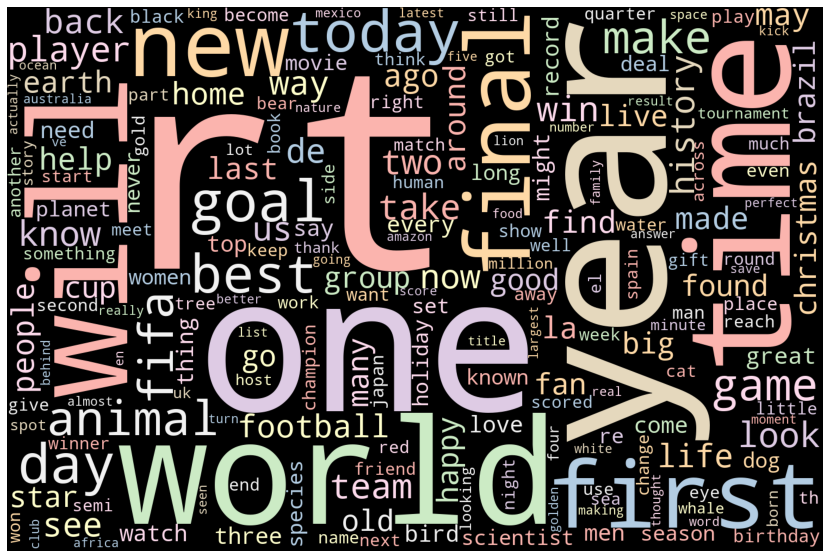

In [ ]:
text = ' '.join(data_examples['text_cleaned'])
text=text.replace('hashtag', '')
text=text.replace('user','')
# Generate word cloud
wordcloud = WordCloud(width= 1500, height = 1000, random_state=1, background_color='black', colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(text)
# Plot
plot_cloud(wordcloud)

### Hashtag WordCloud

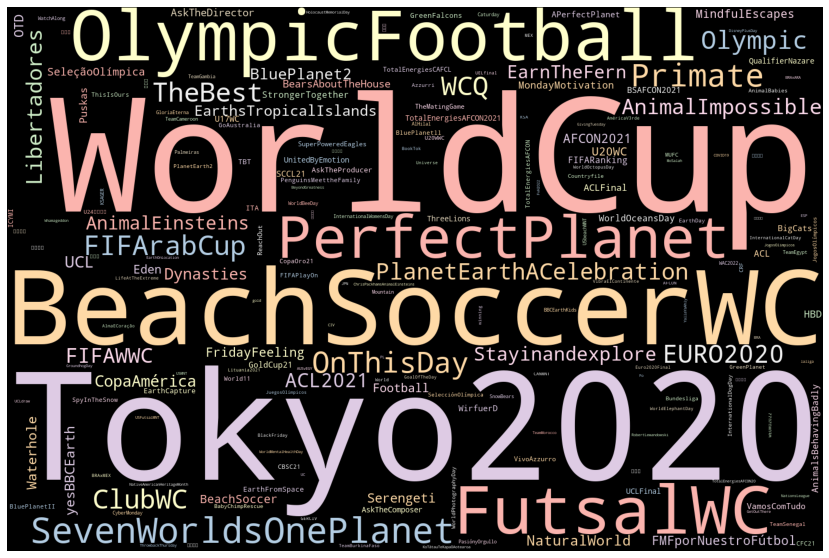

In [ ]:
text = [' '.join(h) for h in data_examples['hashtags']]
text = ' '.join(text)
# Generate word cloud
wordcloud = WordCloud(width= 1500, height = 1000, random_state=1, background_color='black', colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(text)
# Plot
plot_cloud(wordcloud)

### Emoji translated to text -  WordCloud

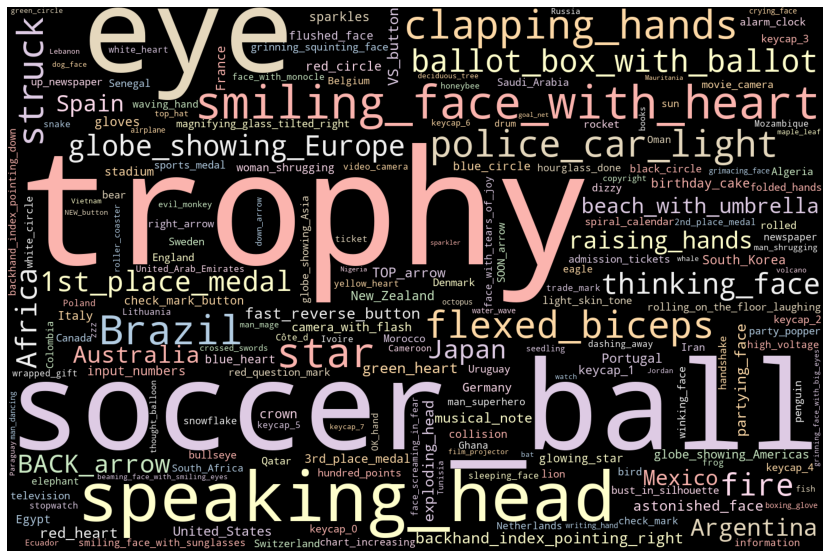

In [ ]:
text = [' '.join(h) for h in data_examples['emojis']]
text = ' '.join(text)
# Generate word cloud
wordcloud = WordCloud(width= 1500, height = 1000, random_state=1, background_color='black', colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(text)
# Plot
plot_cloud(wordcloud)

## Feature extraction

### Counts as features

In [ ]:
validation_examples['hashtag_count'] = [len(h) for h in validation_examples.hashtags]
training_examples['hashtag_count'] = [len(h) for h in training_examples.hashtags]
validation_examples['emoji_count'] = [len(h) for h in validation_examples.emojis]
training_examples['emoji_count'] = [len(h) for h in training_examples.emojis]
validation_examples['word_count'] = [len(h.split()) for h in validation_examples.text_cleaned]
training_examples['word_count'] = [len(h.split()) for h in training_examples.text_cleaned]


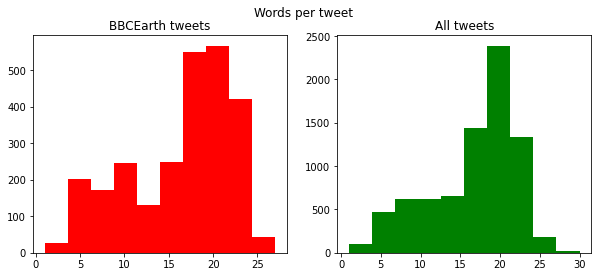

In [ ]:
# PLOTTING WORD-COUNT
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=training_examples[training_examples['user']=='@BBCEarth']['word_count']
ax1.hist(train_words,color='red')
ax1.set_title('BBCEarth tweets')
train_words=training_examples['word_count']
ax2.hist(train_words,color='green')
ax2.set_title('All tweets')
fig.suptitle('Words per tweet')
plt.show()

### Create Vectorizer
This is a simple but still very effective way of representing text. It has great success in language modeling and text classification. It is based on the word count statistics.  
Since bag-of-words representations converts text into a “flat vector of numbers”, it does not remember any original textual sequence and it can destroy the semantic meaning of the text. In other words, it only records how many times each word appears in the text and it does not give any importance to their order. Each word count becomes a dimension for that specific word. The following cell will create features based on the most basic Bag of Word Vectorizer (BoW), using BoW with ngrams = 3 (trigram) and using TF-IDF.

In [ ]:
if VECTORIZER.lower() == 'trigram':
    print("Using Trigram Vectorizer")
    vectorizer = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[3,3], stop_words='english',lowercase=False) 
    x_trigram = vectorizer.fit_transform(data_examples['text_cleaned'])
   
    x_train = x_trigram[train_index]
    x_valid = x_trigram[val_index]
    

elif VECTORIZER.lower() == 'tf-idf':
    print("Using TF-IDF Vectorizer")
    bow_converter = CountVectorizer(tokenizer=lambda doc: doc, stop_words='english',lowercase=False)
    vectorizer = TfidfTransformer(norm=None)
    x_bow = bow_converter.fit_transform(data_examples['text_cleaned'])
    x_tfidf = vectorizer.fit_transform(x_bow)
    
    x_train = x_tfidf[train_index]
    x_valid = x_tfidf[val_index]
    
else: #Default
    print("Using BoW Vectorizer")
    vectorizer = CountVectorizer(tokenizer=lambda doc: doc, stop_words='english',lowercase=False)
    x_bow = vectorizer.fit_transform(data_examples['text_cleaned'])

    x_train = x_bow[train_index]
    x_valid = x_bow[val_index]


model_name= f"logistic_regression_{VECTORIZER.lower()}"
#true labels
y = data_examples['score']
y_train= y[train_index]
y_valid = y[val_index]


Using Trigram Vectorizer


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  % sorted(inconsistent)


###  Add new features (optional)

In [ ]:
if ADD_EXTRA_FEATURES:
    #add features
    word_count = training_examples['word_count'].to_numpy()
    emoji_count = training_examples['emoji_count'].to_numpy()
    hashtag_count = training_examples['hashtag_count'].to_numpy()
    x_train = np.c_[x_train.toarray(), word_count, emoji_count, hashtag_count]

    #add features
    word_count = validation_examples['word_count'].to_numpy()
    emoji_count = validation_examples['emoji_count'].to_numpy()
    hashtag_count = validation_examples['hashtag_count'].to_numpy()
    x_valid = np.c_[x_valid.toarray(), word_count, emoji_count, hashtag_count]



## Train logistic regression model

In [ ]:
%%time
print(f"Training logistic model using {VECTORIZER} Vectorizer")
print(f"----------------------------------------------------")
#FITTING THE CLASSIFICATION MODEL using Logistic Regression
model = LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
model.fit(x_train, y_train)

#Predict y value for test dataset
y_predict = model.predict(x_valid)

print(classification_report(y_valid,y_predict))
print(f"----------------------------------------------------")
f1 = f1_score(y_valid, y_predict, average='weighted')
print('F1 score:',round(f1,3))
print(f"----------------------------------------------------")


#--------------------------
# save the model to disk
#--------------------------
filename = f"{model_dir}/{model_name}.sav"

if VECTORIZER == "TF-IDF":
  with open(filename, 'wb') as fout:
      dill.dump((model, vectorizer, bow_converter), fout)
else:
  with open(filename, 'wb') as fout:
      dill.dump((model, vectorizer), fout)

# save labels:
model_dict = {
    "model_type": 'logistic_regression',
    "id2label": id2label,
    "label2id": label2id
}

with open(f"{model_dir}/label_config.json", 'w') as fp:
    json.dump(model_dict, fp)

# save score:
model_cfg = {
    "model_type": 'logistic_regression',
    "vectorizer": VECTORIZER,
    "f1": f1,

}

with open(f"{model_dir}/model_cfg.json", 'w') as fp:
    json.dump(model_cfg, fp)    
  

Training logistic model using Trigram Vectorizer
----------------------------------------------------
              precision    recall  f1-score   support

           0       0.46      0.65      0.54       640
           1       0.25      0.27      0.26       640
           2       0.52      0.28      0.36       640

    accuracy                           0.40      1920
   macro avg       0.41      0.40      0.39      1920
weighted avg       0.41      0.40      0.39      1920

----------------------------------------------------
F1 score: 0.388
----------------------------------------------------
CPU times: user 3.3 s, sys: 2.38 s, total: 5.69 s
Wall time: 2.98 s


### Validation and visualization

In [ ]:
#Validation
prediction_ids = model.predict(x_valid)
prediction_labels = []
count = 0
for prediction in prediction_ids:
  prediction_labels.append(id2label[prediction])    
df_data=validation_examples.copy()      
df_data["prediction"] = prediction_labels
df_data["prediction_ids"] = prediction_ids
df_data = df_data.rename(columns={'user': 'truth'})
print(classification_report(df_data["truth"] ,df_data["prediction"]))

               precision    recall  f1-score   support

    @BBCEarth       0.46      0.65      0.54       640
     @FIFAcom       0.25      0.27      0.26       640
@mental_floss       0.52      0.28      0.36       640

     accuracy                           0.40      1920
    macro avg       0.41      0.40      0.39      1920
 weighted avg       0.41      0.40      0.39      1920



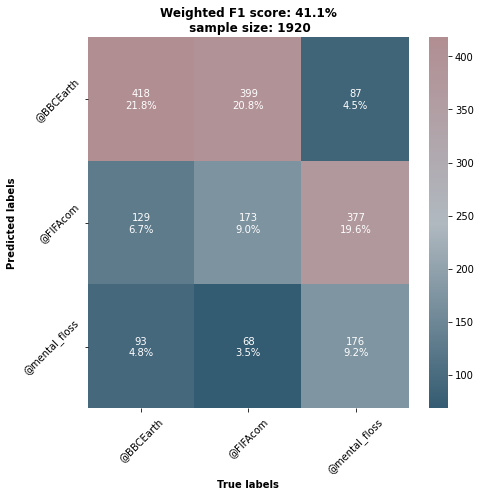

In [ ]:
#Visualization
def make_labels(cf_matrix,n):
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.1%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(n,n)
    
    return labels



fig, axis= plt.subplots(ncols=1, figsize=(7,7))

ax=axis

f1= f1_score(df_data["prediction"], df_data["truth"], average='weighted')
ax.set_title(f"Weighted F1 score: {f1*100:.1f}%\n sample size: {df_data.shape[0]}",weight="bold")

labels_used=[value for key,value in id2label.items() if value in df_data["truth"].unique()]
length=len(labels_used)
conf_matrix= confusion_matrix(df_data["prediction"], df_data["truth"])

labels=make_labels(conf_matrix, length)
sns.heatmap(conf_matrix, annot=labels, fmt='',cmap=cmap, ax=ax )
ax.set_xlabel("True labels",weight="bold")
ax.set_xticklabels(labels_used, rotation=45)
ax.set_ylabel("Predicted labels",weight="bold")
ax.set_yticklabels(labels_used, rotation=45)

fig.tight_layout()
fig.savefig(f"{model_dir}/confusion_matrix.png")

# Part 3  - Medium model - LSTM

## Imports

In [ ]:
import os
import pandas as pd
import tweepy
from pathlib import Path
import yaml
import time
import numpy as np
import pickle
import random
import json

import tensorflow as tf
import keras
import sklearn
from keras.layers import Input,Embedding, LSTM, Dense,SpatialDropout1D,Bidirectional
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.client import device_lib
from sklearn.metrics import f1_score, confusion_matrix,classification_report
from keras import backend as K


#Visualization 
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import seaborn as sns


#own code
from fagkveld.model.utils import PreprocessInputText
# from fagkveld.model.transformer_models import Bert

# Colors used 
cmap = clr.LinearSegmentedColormap.from_list('ANB color', ['#335B71',"#B0B9C0",'#B18E92'], N=256)


resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))


# Use GPU
os.environ['CUDA_VISIBLE_DEVICES']= '0'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Use seed for reproducibility
seed=42
tf.keras.utils.set_random_seed(seed)
tf.random.set_seed(seed)
random.seed(seed)
np.random.seed(seed)



INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.93.144.74:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.93.144.74:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]
Num GPUs Available:  0


## Admin

In [ ]:
#Training data
PEER_GROUP_NAME="CHOOSE YOUR OWN GROUP"#"peer_group_code_example"
SHARE_VALIDATION_DATA=0.2

#Model parameters
MAX_NB_WORDS=50000
MAX_SEQUENCE_LENGTH=128
EMBEDDING_DIM=100


# Train parameters 
PATIENCE=5
BATCH_SIZE=32
EPOCHS=50
LEARNING_RATE=0.001
TRAIN_EMBEDDING="CHOOSE IF EMBEDDING LAYER SHOULD BE TRAINED " # False or True

#Model Name
MODEL_NAME=f"LSTM_{PEER_GROUP_NAME}_{str(TRAIN_EMBEDDING).lower()}"
model_dir=model_path+f"/{MODEL_NAME}"
Path(model_dir).mkdir(parents=True, exist_ok=True)




### Save admin data

In [ ]:
# saving

cfg = {
    "MAX_NB_WORDS":MAX_NB_WORDS,
    "MAX_SEQUENCE_LENGTH":MAX_SEQUENCE_LENGTH,
    "PEER_GROUP_NAME":PEER_GROUP_NAME,
}

with open(model_dir+"/config.json", 'w') as fp:
    json.dump(cfg, fp)

## Preprocess data

In [ ]:
# Read data
data_examples = pd.read_csv(data_path+f"/train/{PEER_GROUP_NAME}.csv")

#create and save score list
id2label = data_examples.set_index("score").to_dict()["user"]
label2id = {}
for key, value in id2label.items(): 
    label2id[value]=key
# save labels:
label_dict = {
"model_type": MODEL_NAME,
"id2label": id2label,
"label2id": label2id
}

with open(model_dir+"/label_config.json", 'w') as fp:
    json.dump(label_dict, fp)

elements = int(data_examples.shape[0]/len(label2id)*SHARE_VALIDATION_DATA)
data_examples.sort_values(by="time_created",  axis =0, ascending=False, inplace=True)

validation_examples = data_examples.groupby('score').head(elements)
training_examples = data_examples[~data_examples.index.isin(validation_examples.index)].sample(frac=1).reset_index(drop=True)
validation_examples = validation_examples.sample(frac=1).reset_index(drop=True)


text_processor = PreprocessInputText()
print("----------- Processing training data -----------------")
training_examples = text_processor.process_text(training_examples)
print("----------- Processing validation data -----------------")
validation_examples = text_processor.process_text(validation_examples)

----------- Processing training data -----------------
cleaning text
replacing hashtags
replacing usernames
replacing urls
removing emojis
fixing special characters
text to lower case
----------- Processing validation data -----------------
cleaning text
replacing hashtags
replacing usernames
replacing urls
removing emojis
fixing special characters
text to lower case


## Tokenizer data

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer( num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(training_examples['text_cleaned'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))


# Traing data 
y_train = training_examples['score'].values
y_train=tf.keras.utils.to_categorical(y_train, num_classes=len(label2id))


x_train = tokenizer.texts_to_sequences(training_examples['text_cleaned'].values)
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of training data tensor:', x_train.shape)

# Validation data
y_valid = validation_examples['score'].values
y_valid=tf.keras.utils.to_categorical(y_valid, num_classes=len(label2id))

x_valid = tokenizer.texts_to_sequences(validation_examples['text_cleaned'].values)
x_valid = tf.keras.preprocessing.sequence.pad_sequences(x_valid, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of validation data tensor:', x_valid.shape)

# Save tokenizer 
with open(model_dir +'/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


Found 22894 unique tokens.
Shape of training data tensor: (15590, 128)
Shape of validation data tensor: (3894, 128)


## Train a model

### Build the model

In [ ]:
def create_model():
  input_layer= Input(shape=(x_train.shape[1],))
  embedding_layer=Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=x_train.shape[1], trainable=TRAIN_EMBEDDING)(input_layer)
  dropout_layer=SpatialDropout1D(0.2,name="Dropout")(embedding_layer) # Drops out word for all channels 
  LSTM_1=LSTM(16, dropout=0.2, recurrent_dropout=0,return_sequences=True, activation='tanh',recurrent_activation="sigmoid")(dropout_layer)
  LSTM_2=LSTM(16, dropout=0.2, recurrent_dropout=0,return_sequences=False, activation='tanh',recurrent_activation="sigmoid")(LSTM_1)


  output_layer=Dense(len(id2label), activation='softmax')(LSTM_2)
  model=Model(inputs=input_layer, outputs=output_layer, name=MODEL_NAME)
  return model
model=create_model()
model.summary()

Model: "LSTM_peer_group_code_example_true"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 128, 100)          5000000   
                                                                 
 Dropout (SpatialDropout1D)  (None, 128, 100)          0         
                                                                 
 lstm_4 (LSTM)               (None, 128, 16)           7488      
                                                                 
 lstm_5 (LSTM)               (None, 16)                2112      
                                                                 
 dense_2 (Dense)             (None, 6)                 102       
                                                                 
Total params: 5,009,702
Trainable

In [ ]:
%%time

# Callbakcs
early_stop  = EarlyStopping(monitor='val_loss', patience=PATIENCE, min_delta=0.00001)
check_point = ModelCheckpoint(model_dir+"/best_model.h5", monitor='val_loss', save_best_only=True)
callbacks=[early_stop,check_point]

#Optimizer 
optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

strategy = tf.distribute.TPUStrategy(resolver)
with strategy.scope():
  # Create model
  model=create_model()

  #Compile model
  model.compile(loss='categorical_crossentropy', steps_per_execution = 50, optimizer=optimizer, metrics=['accuracy'])


  # Train model
  history = model.fit(x=x_train, y=y_train, validation_data=[x_valid, y_valid], 
                      epochs=EPOCHS,shuffle=True, batch_size=BATCH_SIZE,workers=-1,verbose=1,
                      callbacks=callbacks)

#load the best model back
model =  tf.keras.models.load_model(model_dir+"/best_model.h5")


#F1 score 
prediction = model.predict(x_valid)

# Sturcture the data for output
df_evaluate=pd.DataFrame()
df_evaluate["truth"]=np.argmax(y_valid, axis=1)
df_evaluate["prediction"]=np.argmax(prediction, axis=1)
f1= f1_score(df_evaluate["prediction"], df_evaluate["truth"], average='weighted')

print(f"The models F1 score is: {f1}")

model_cfg = {
    "PATIENCE":PATIENCE,
    "BATCH_SIZE":BATCH_SIZE,
    "EPOCHS":EPOCHS,
    "LEARNING_RATE":LEARNING_RATE,
    "f1":f1
}

with open(model_dir+"/model_cfg.json", 'w') as fp:
    json.dump(model_cfg, fp)


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Epoch 1/50
488/488 [==============================] - 26s 53ms/step - loss: 1.1650 - accuracy: 0.5536 - val_loss: 0.8364 - val_accuracy: 0.6970
Epoch 2/50
488/488 [==============================] - 8s 16ms/step - loss: 0.5886 - accuracy: 0.7952 - val_loss: 0.8110 - val_accuracy: 0.7078
Epoch 3/50
488/488 [==============================] - 7s 15ms/step - loss: 0.3555 - accuracy: 0.8845 - val_loss: 0.8890 - val_accuracy: 0.7085
Epoch 4/50
488/488 [==============================] - 7s 15ms/step - loss: 0.2349 - accuracy: 0.9255 - val_loss: 0.9609 - val_accuracy: 0.7114
Epoch 5/50
488/488 [==============================] - 7s 15ms/step - loss: 0.1672 - accuracy: 0.9484 - val_loss: 1.0855 - val_accuracy: 0.7001
Epoch 6/50
488/488 [==============================] - 7s 15ms/step - loss: 0.1364 - accuracy: 0.9577 - val_loss: 1.1063 - val_accuracy: 0.7124
Epoch 7/50
488/488 [==============================] - 8s 15ms/step - loss: 0.1076 - accuracy: 0.9690 - val_loss: 1.1859 - val_accuracy: 0.702

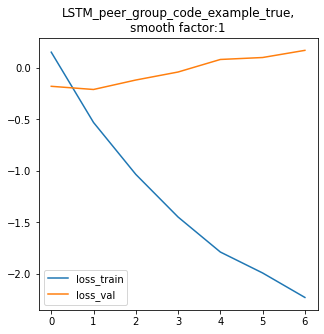

In [ ]:
SMOOTHING_FACTOR=1

df_history=pd.DataFrame(index=range(len(history.history['loss'])))
df_history["loss"]=np.log(history.history['loss'])
df_history["loss_train"]=df_history["loss"].rolling(SMOOTHING_FACTOR,win_type=None).mean()
df_history['val_loss']=np.log(history.history['val_loss'])
df_history["loss_val"]=df_history['val_loss'].rolling(SMOOTHING_FACTOR,win_type=None).mean()


fig, ax= plt.subplots(ncols=1, figsize=(5,5))
df_history[["loss_train","loss_val"]].plot(title=f'{MODEL_NAME},\nsmooth factor:{SMOOTHING_FACTOR}', ax=ax)
fig.savefig(model_dir+"/training.png")

## Evaluate results 

In [ ]:
#load the best model back
model =  tf.keras.models.load_model(model_dir+"/best_model.h5")


prediction = model.predict(x_valid)

# Sturcture the data for output
df_evaluate=pd.DataFrame()
df_evaluate["truth"]=np.argmax(y_valid, axis=1)
df_evaluate["prediction"]=np.argmax(prediction, axis=1)

unique, counts = np.unique(np.argmax(y_valid, axis=1), return_counts=True)

df_evaluate_with_names=df_evaluate.copy()
df_evaluate_with_names.replace(id2label,inplace=True)
print(classification_report(df_evaluate_with_names["truth"], df_evaluate_with_names["prediction"]))

                precision    recall  f1-score   support

     @BBCEarth       0.72      0.78      0.75       649
      @FIFAcom       0.90      0.83      0.86       649
   @IFLScience       0.92      0.71      0.80       649
@KimKardashian       0.68      0.77      0.72       649
   @funnyordie       0.56      0.42      0.48       649
 @mental_floss       0.55      0.73      0.63       649

      accuracy                           0.71      3894
     macro avg       0.72      0.71      0.71      3894
  weighted avg       0.72      0.71      0.71      3894



### Confusion matrix

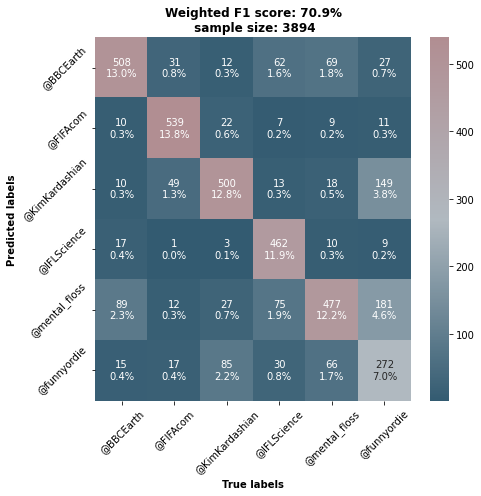

In [ ]:
def make_labels(cf_matrix,n):
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.1%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(n,n)
    
    return labels


df_data=df_evaluate.copy()
fig, ax= plt.subplots(ncols=1, figsize=(7,7))
f1= f1_score(df_data["prediction"], df_data["truth"], average='weighted')
ax.set_title(f"Weighted F1 score: {f1*100:.1f}%\n sample size: {df_data.shape[0]}",weight="bold")

labels_used=[value for key,value in id2label.items() if key in df_data["prediction"].unique()]
length=len(labels_used)
conf_matrix= confusion_matrix(df_data["prediction"], df_data["truth"])

labels=make_labels(conf_matrix, length)
sns.heatmap(conf_matrix, annot=labels, fmt='',cmap=cmap, ax=ax )
ax.set_xlabel("True labels",weight="bold")
ax.set_xticklabels(labels_used, rotation=45)
ax.set_ylabel("Predicted labels",weight="bold")
ax.set_yticklabels(labels_used, rotation=45)

fig.tight_layout()
fig.savefig(model_dir + "/confusion_matrix.png")

# Part 4 - "Who would write this" app

## Imports

In [ ]:
import panel as pn
import panel.widgets as pnw

import os
import pandas as pd
import tweepy
from pathlib import Path
import yaml
import numpy as np
import tensorflow as tf
import dill
from sklearn.feature_extraction.text import CountVectorizer



#Visualization 
import matplotlib.pyplot as plt
import seaborn as sns

import munch
import pickle
import json

#own code
from fagkveld.model.utils import PreprocessInputText
from fagkveld.model.transformer_models import Bert

## The actual app

No handles with labels found to put in legend.


logistic_regression_trigram


Row
    [0] ParamFunction(function)
    [1] Column
        [0] Select(options=['logistic_regression_trig...], value='logistic_regression_trigr...)
        [1] Markdown(str)
        [2] CheckBoxGroup(name='Select personas', options=['@BBCEarth', ...], value=['@BBCEarth', ...])
        [3] Markdown(str)
        [4] Markdown(str)
        [5] TextInput(name='Text Input', placeholder='Enter a string here...')
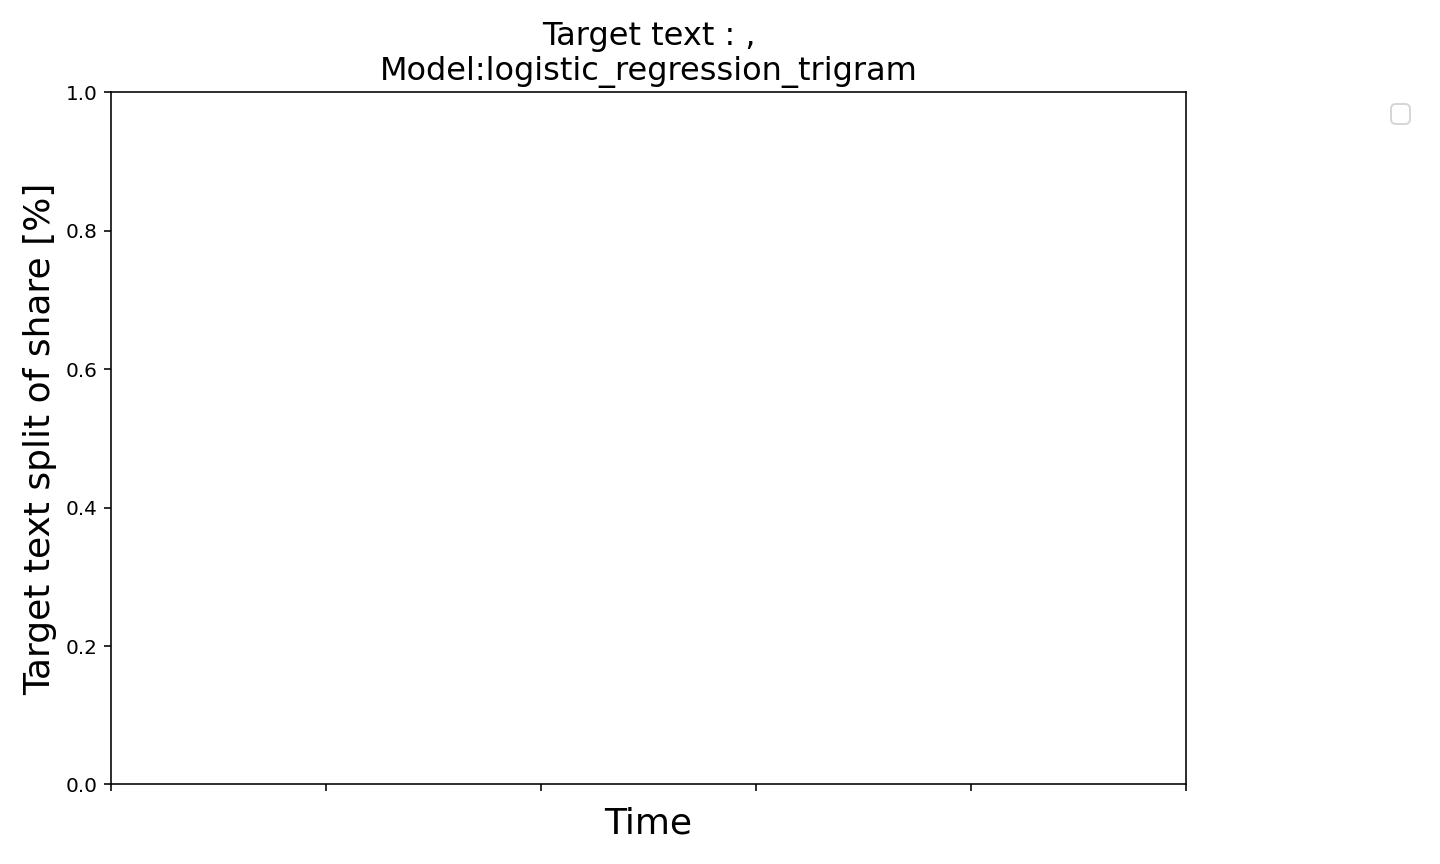

selected model LSTM_peer_group_code_example_true

In [ ]:
# %%time
class my_data_model_button:
    def __init__(self):
            self.model_name=None
            self.df_output =None
            self.df_target =None
            self.model=None
            self.cfg=None
            self.model_cfg=None
            self.tokenizer=None
            self.tokenizer=None
            self.lable_cfg=None

            
    def __str__(self):
            return f"{self.model_name},{self.df_output}"
            
    def update_target(self,target_text):
        """ Updates target data based on target name """
        
        # read input
        df_target= pd.DataFrame.from_dict({"text":[target_text],"user":["NA"]})
        text_processor = PreprocessInputText()
        df_target = text_processor.process_text(df_target)
        self.df_target= df_target
     


    def update_model(self,model_name):
        """ Updates the model, tokenizer, configure file based on model name """       
        
        with open(model_path +f'/{model_name}/label_config.json', 'rb') as handle:
            label_config = json.load(handle)
        self.lable_cfg=label_config


        if model_name=="BERT":
            model = Bert()
            model.load_model_from_file(model_path +f"/{model_name}")
            self.model=model
            self.model_name=model_name
            self.tokenizer=None
            self.cfg=None
            self.model_cfg=None

            with open(model_path +f'/{model_name}/model_cfg.json', 'rb') as handle:
                model_cfg = json.load(handle)

        if "logistic_regression" in model_name:
            # print(model_name)
            if "tf-idf" in model_name.lower():
              model, vectorizer, bow_converter = dill.load(open(model_path+f"/{model_name}/{model_name}.sav", 'rb'))
              self.bow_converter = bow_converter
            else:
              model, vectorizer = dill.load(open(model_path+f"/{model_name}/{model_name}.sav", 'rb'))

            self.model = model
            self.vectorizer = vectorizer
            self.model_name=model_name
            self.tokenizer=None
            self.cfg=None
            self.model_cfg=None
            with open(model_path +f'/{model_name}/model_cfg.json', 'rb') as handle:
                model_cfg = json.load(handle)

        if "LSTM" in model_name:
            # Read model and make prediction 
            with open(model_path +f'/{model_name}/tokenizer.pickle', 'rb') as handle:
                tokenizer = pickle.load(handle)
            with open(model_path +f'/{model_name}/config.json', 'rb') as handle:
                cfg = json.load(handle)
            with open(model_path +f'/{model_name}/model_cfg.json', 'rb') as handle:
                model_cfg = json.load(handle)

            model =  tf.keras.models.load_model(model_path +f'/{model_name}/best_model.h5')

            self.model=model
            self.tokenizer=tokenizer
            self.cfg=cfg
            self.model_cfg=model_cfg
            self.model_name=model_name
      

        update_df_output=False
    def update_df_output(self,target_text,model_name):
        """ Calls update of target data and model given that changes have been made.
        Also handles structuring of output for the rendering function"""      
    
        update_df_output=False
        self.update_target(target_text)

        if self.model_name!=model_name:
            self.update_model(model_name)

        if self.model_name=="BERT":
            df_output = self.model.predict(self.df_target)

        elif "logistic_regression" in self.model_name:
         
            if "tf-idf" in self.model_name.lower():
              x_bow = self.bow_converter.transform(self.df_target['text_cleaned'])
              x_test = self.vectorizer.transform(x_bow)
            else:
              x_test = self.vectorizer.transform(self.df_target['text_cleaned'])

            prediction_ids = self.model.predict(x_test)
            prediction = self.model.predict_proba(x_test)
            df_output=pd.DataFrame()
            df_output["prediction_id"] = prediction_ids
            df_output["prediction"] = df_output.apply(lambda x: self.lable_cfg["id2label"][str(x["prediction_id"])], axis=1)
            # Add for each category
            for key, value in self.lable_cfg["id2label"].items():
                df_output[f"share_{value}"]=prediction[:,int(key)]

        else:
            tokenized_text = self.tokenizer.texts_to_sequences(self.df_target['text_cleaned'].values)
            tokenized_text = tf.keras.preprocessing.sequence.pad_sequences(tokenized_text, maxlen=self.cfg["MAX_SEQUENCE_LENGTH"])
            prediction = self.model.predict(tokenized_text)

            # Sturcture the data for output
            df_output=pd.DataFrame()
            df_output["prediction_id"]=np.argmax(prediction, axis=1)
            df_output["prediction"]=df_output.apply(lambda x: self.lable_cfg["id2label"][str(x["prediction_id"])], axis=1)

            # Add for each category
            for key, value in self.lable_cfg["id2label"].items():
                df_output[f"share_{value}"]=prediction[:,int(key)]

        # Add time element
        self.df_output=df_output

    def prepare_data(self,target_text,model_name, selection):    
        #Update input parameters 
        self.update_df_output(target_text,model_name)


        df_temp=self.df_output.copy()
        df_temp=df_temp[[f"share_{c}" for c in selection]]
        df_temp=df_temp.div(df_temp.sum(axis=1), axis=0).fillna(0).T
        df_temp.index=[x.replace("share_","") for x in df_temp.index]
        df_temp.columns=["share"]
        df_temp["share"]=df_temp["share"]*100
        df_temp.sort_values(by="share", inplace=True, axis=0, ascending=False)
        df_temp=df_temp.T

        fig, ax = plt.subplots(figsize=(10,6))
        
        palette = sns.color_palette('tab10', n_colors=df_temp.shape[1], desat=1)
        if target_text!="":
            df_temp.plot(kind="bar", color=palette,stacked=False,ax=ax, alpha=0.8, width=1)
        ax.legend(loc='upper center', bbox_to_anchor=(1.2, 1.0),fontsize=12)

        ax.set_xlabel("Time",fontsize=18)
        ax.set_ylabel("Target text split of share [%]",fontsize=18)
        ax.set_xticklabels([""], rotation=45)
      
        
        plt.title(f'Target text : {target_text},\nModel:{self.model_name}', fontsize=16)
        fig.tight_layout(h_pad=6)
        plt.close() 
        
        return fig

    
pn.extension() 

# Get trained models 
possible_models = [x.parts[-1] for x in Path(model_path).glob('[!.]*') ]
select_model  = pn.widgets.Select(name='Select model', options=possible_models)


text_input = pn.widgets.TextInput(name='Text Input', placeholder='Enter a string here...')

my_data_model_button=my_data_model_button()
my_data_model_button.update_model(possible_models[0])

options=[v for k, v, in my_data_model_button.lable_cfg["id2label"].items()]
selection = pn.widgets.CheckBoxGroup(name='Select personas', value=options, options=options, inline=False)
# - --------------- Dependencies 
@pn.depends(select_model, watch=True)
def load_twitter_accounts(event, selection=selection,my_data_model_button=my_data_model_button,select_model=select_model):
    with open(model_path +f'/{select_model.value}/label_config.json', 'rb') as handle:
            label_config = json.load(handle)
 
    options=[v for k, v, in label_config["id2label"].items()]
    selection.options=options
    selection.value=options

reactive_plots = pn.bind(my_data_model_button.prepare_data,text_input,select_model,selection)
sub_widget    = pn.Column(select_model, "<br>\n# Select peer group", selection, " ", " ",text_input)
widgets = pn.Row(reactive_plots, sub_widget)



plt.close()

widgets



# Part 5 - Twitter persona

## Imports

In [ ]:
import panel as pn
import panel.widgets as pnw

import os
import pandas as pd
import tweepy
from pathlib import Path
import yaml
import numpy as np

#Visualization 
import matplotlib.pyplot as plt
import seaborn as sns

import munch
import pickle
import json
import dill



from keras.layers import Input,Embedding, LSTM, Dense,SpatialDropout1D,Bidirectional
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.client import device_lib
from sklearn.metrics import f1_score, confusion_matrix,classification_report
from keras import backend as K
import tensorflow as tf

#own code
from fagkveld.model.utils import PreprocessInputText
from fagkveld.model.transformer_models import Bert

## The App

In [ ]:

%%time
class my_data_model_ts:
    
    def __init__(self):
            self.model_name=None
            self.target_name=None
            self.df_output =None
            self.df_target =None
            self.model=None
            self.cfg=None
            self.model_cfg=None
            self.tokenizer=None
            self.lable_cfg=None
    
    def update_target(self,target_name):
        """ Updates target data based on target name """
        
        # read input
        df_target= pd.read_csv(Path(f"{data_path}/test/") / f"{target_name}.csv" )
        text_processor = PreprocessInputText()
        df_target = text_processor.process_text(df_target)
        self.df_target= df_target
        self.target_name=target_name
        #print("Target updated")
                    

    def update_model(self,model_name):
        """ Updates the model, tokenizer, configure file based on model name """     

        with open(model_path +f'/{model_name}/label_config.json', 'rb') as handle:
            label_config = json.load(handle)
        self.lable_cfg=label_config


        if "BERT" in model_name:
            model = Bert()
            model.load_model_from_file(f"{model_path}/{model_name}")
            self.model=model
            self.model_name=model_name
            self.tokenizer=None
            self.cfg=None
            #self.model_cfg=None
            with open(model_path +f'/{model_name}/model_cfg.json', 'rb') as handle:
                self.model_cfg = json.load(handle)

        elif "logistic_regression" in model_name:
            
            if "tf-idf" in model_name.lower():
              model, vectorizer, bow_converter = dill.load(open(model_path+f"/{model_name}/{model_name}.sav", 'rb'))
              self.bow_converter = bow_converter
            else:
              model, vectorizer = dill.load(open(model_path+f"/{model_name}/{model_name}.sav", 'rb'))

            self.model = model
            self.vectorizer = vectorizer
            self.model_name=model_name
            self.tokenizer=None
            self.cfg=None
            #self.model_cfg=None
            with open(model_path +f'/{model_name}/model_cfg.json', 'rb') as handle:
                self.model_cfg = json.load(handle)

        else:

            # Read model and make prediction 
            
            with open(f'{model_path}/{model_name}/tokenizer.pickle', 'rb') as handle:
                tokenizer = pickle.load(handle)

            with open(model_path +f'/{model_name}/config.json', 'rb') as handle:
                cfg = json.load(handle)
            with open(model_path +f'/{model_name}/model_cfg.json', 'rb') as handle:
                model_cfg = json.load(handle)


            model =  tf.keras.models.load_model(f'{model_path}/{model_name}/best_model.h5')

            self.model=model
            self.tokenizer=tokenizer
            self.cfg=cfg
            self.model_cfg=model_cfg
            self.model_name=model_name
        #print(f"Model updated")
    
    def update_df_output(self,target_name,model_name):
        """ Calls update of target data and model given that changes have been made.
        Also handles structuring of output for the rendering function"""      
 
        update_df_output=True
        self.update_target(target_name)
        self.update_model(model_name)



        if "BERT" in self.model_name:
            print("Bert")
            df_output = self.model.predict(self.df_target)
        
        elif "logistic_regression" in self.model_name:
            
            if "tf-idf" in self.model_name.lower():
              x_bow = self.bow_converter.transform(self.df_target['text_cleaned'])
              x_test = self.vectorizer.transform(x_bow)
            else:
              x_test = self.vectorizer.transform(self.df_target['text_cleaned'])

            prediction_ids = self.model.predict(x_test)
            prediction = self.model.predict_proba(x_test)
            df_output=pd.DataFrame()
            df_output["prediction_id"] = prediction_ids
            df_output["prediction"] = df_output.apply(lambda x: self.lable_cfg["id2label"][str(x["prediction_id"])], axis=1)
            # Add for each category
            for key, value in self.lable_cfg["id2label"].items():
                df_output[f"share_{value}"]=0
            for key, value in self.lable_cfg["id2label"].items():
                df_output[f"share_{value}"]=prediction[:,int(key)]

                
        else:
            # Make prediction
            tokenized_text = self.tokenizer.texts_to_sequences(self.df_target['text_cleaned'].values)
            tokenized_text = tf.keras.preprocessing.sequence.pad_sequences(tokenized_text, maxlen=self.cfg["MAX_SEQUENCE_LENGTH"])
            prediction = self.model.predict(tokenized_text)

            # Sturcture the data for output
            df_output=pd.DataFrame()
            df_output["prediction_id"]=np.argmax(prediction, axis=1)
            df_output["prediction"]=df_output.apply(lambda x: self.lable_cfg["id2label"][str(x["prediction_id"])], axis=1)

            # Add for each category
            for key, value in self.lable_cfg["id2label"].items():
                df_output[f"share_{value}"]=0
            for key, value in self.lable_cfg["id2label"].items():
                df_output[f"share_{value}"]=prediction[:,int(key)]

        # Add time element
        df_output["time"]=self.df_target["time_created"]
        df_output["time"]=pd.to_datetime(df_output["time"])
        df_output.set_index("time", inplace=True)
        self.df_output=df_output

      
    
    def plot_data(self,df_output_grouped,df_output,df_share):
        #-------------------- plot figure -----------------------
        gridkw = dict(width_ratios=[5, 1])
        fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw=gridkw,figsize=(10,6))
        
        if df_share.shape[0]>=1: # Only draw plot if a member of peergroup is seelected
            # Colors and order
            palette = sns.color_palette('tab10', n_colors=df_share.shape[0], desat=1)

            hue_order=df_share.index.tolist()
            alpha=0.5

            ax=ax1
            sns.lineplot(data=df_output_grouped, x="time", y="share", hue="persona",hue_order=hue_order,palette=palette,lw=5,alpha=alpha,ax=ax)
            ax.legend().remove()

            #------------- Aggregated plot ------------- 
            ax=ax2
            df_share_plot=df_share
            df_share=df_share/df_share.sum()*100
            df_share_plot=df_share.T.copy()

            df_share_plot.plot(kind="bar", color=palette ,stacked=False,ax=ax, alpha=alpha, width=2)
            for count, x in enumerate(df_share.index.tolist()):
                ax.containers[count][0].set_edgecolor('white')
                ax.containers[count][0].set_linewidth(1)

        ax=ax1 
        ax.set_xlabel("Time",fontsize=18)
        ax.set_ylabel("Share of twitter messages [%]",fontsize=18)
        ax.tick_params(axis='both', which='major', labelsize=18)
        ax.tick_params(axis='x', which='major',  rotation=45)

        ax=ax2
        ax.legend(loc='upper center', bbox_to_anchor=(2., 1.0),fontsize=12)
        ax.set_xlabel("All\ntweets",fontsize=18)
        ax.set_xticklabels([""], rotation=45)
        ax.tick_params(axis='both', which='major', labelsize=18)
        try:
            f1=round(self.model_cfg["f1"],2)
        except Exception as e:
            f1=np.nan
        fig.suptitle(f'Target: {self.target_name}, model: {self.model_name}, f1 score: {f1}', fontsize=16)
 

        fig.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.close() 
        return fig
    
    def prepare_data(self,target_name, model_name, selection=[""], window=6):
        
        
        #Update input parameters 
        self.update_df_output(target_name,model_name)
        # print(model_name)

        df_temp=self.df_output[[f"share_{c}" for c in selection] ].copy()

        df_temp_share=pd.DataFrame(index=[c for c in selection ])
        df_temp_share["prediction"]=0
        for index, value in self.df_output["prediction"].value_counts().iteritems():
          df_temp_share.loc[index,"prediction"]=value



        # Add rolling mean
        df_temp_grouped = df_temp.copy().groupby(pd.Grouper(freq="M")).sum()
        
        df_temp_grouped=df_temp_grouped.div(df_temp_grouped.sum(axis=1), axis=0).fillna(0)
        df_temp_grouped.dropna(how="any", axis=0, inplace=True)
        df_temp_grouped=df_temp_grouped.rolling(window=window, axis=0).mean()
        df_temp_grouped.dropna(how="any", axis=0, inplace=True)

        df_temp_grouped=df_temp_grouped.melt(var_name="persona", value_name="share", ignore_index=False)
        df_temp_grouped.reset_index(inplace=True)
        df_temp_grouped["persona"]=df_temp_grouped["persona"].apply(lambda x: x.replace("share_",""))
        df_temp_grouped["share"]=df_temp_grouped["share"].apply(lambda x: x*100)
  
        return self.plot_data(df_temp_grouped, df_temp,df_temp_share)
    



CPU times: user 49 µs, sys: 0 ns, total: 49 µs
Wall time: 55.8 µs


Row
    [0] ParamFunction(function)
    [1] Column
        [0] Select(options=['@haraldopdahl', ...], value='@haraldopdahl')
        [1] Select(options=['logistic_regression_trig...], value='logistic_regression_trigr...)
        [2] Markdown(str)
        [3] CheckBoxGroup(name='Select personas', options=['@BBCEarth', ...], value=['@BBCEarth', ...])
        [4] Markdown(str)
        [5] Markdown(str)
        [6] IntSlider(end=12, name='Average over # months', start=1, value=6)
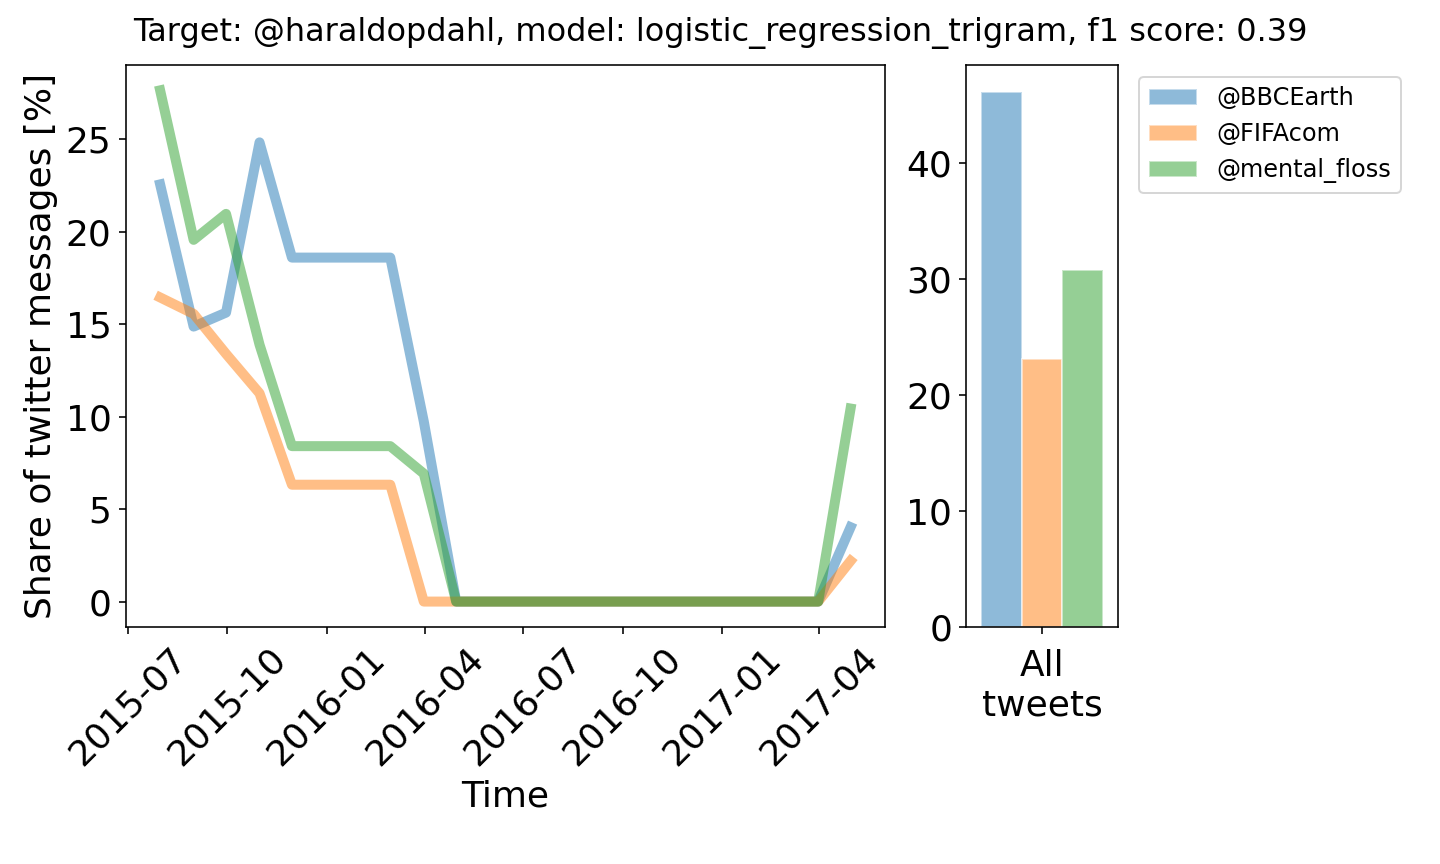

In [ ]:
pn.extension() 

# input parameters
possible_target = [x.parts[-1].replace(".csv","") for x in Path(data_path+"/test/").glob('*.csv')]
select_target  = pn.widgets.Select(name='Select target names', options=possible_target)


# Get trained models 
possible_models = [x.parts[-1] for x in Path(model_path).glob('[!.]*') ]
select_model  = pn.widgets.Select(name='Select model', options=possible_models)

window  = pnw.IntSlider(name='Average over # months', value=6, start=1, end=12)

my_data_model=my_data_model_ts()

my_data_model.update_model(possible_models[0])

options=[v for k, v, in my_data_model.lable_cfg["id2label"].items()]
selection = pn.widgets.CheckBoxGroup(name='Select personas', value=options, options=options, inline=False)


@pn.depends(select_model, watch=True)
def load_twitter_accounts(event, selection=selection,my_data_model_button=my_data_model_button,select_model=select_model):
    with open(model_path +f'/{select_model.value}/label_config.json', 'rb') as handle:
            label_config = json.load(handle)
    # print("selected model",select_model.value)
    options=[v for k, v, in label_config["id2label"].items()]
    selection.options=options
    selection.value=options


reactive_plots = pn.bind(my_data_model.prepare_data,select_target,select_model,selection,window)
sub_widget    = pn.Column(select_target,select_model, "<br>\n# Select peer group", selection, " ", " ",window)
widgets_ts = pn.Row(reactive_plots, sub_widget)


plt.close()  
widgets_ts
# reactive_plots